In [1]:
import pandas as pd
import re
import nltk
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

warnings.filterwarnings(action='ignore')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gsaik\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gsaik\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\gsaik\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gsaik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tweets_df = pd.read_csv('tsla-tweets.csv').drop(['Unnamed: 0'], axis=1)
tweets_df.date = pd.to_datetime(tweets_df.date)

In [3]:
def clean(df):
    df['cleaned_tweet'] = df.tweet.map(lambda x: re.sub(r'http.*', '', x + ' '))
    df.cleaned_tweet = df.cleaned_tweet.map(lambda x: re.sub(r'[^a-zA-Z#]', ' ', x).lower())
    stopword_list = stopwords.words('english')
    df.cleaned_tweet = df.cleaned_tweet.map(lambda x: [w for w in word_tokenize(x) if w not in stopword_list])

clean(tweets_df)

In [4]:
def lemmatize(tweets):
    for i in range(len(tweets)):
        pos_tags = nltk.pos_tag(tweets[i])
        wordnet_tags = [wordnet.ADJ if j[1].startswith('J') else
                        wordnet.NOUN if j[1].startswith('N') else
                        wordnet.ADV if j[1].startswith('R') else
                        wordnet.VERB if j[1].startswith('V') else wordnet.NOUN for j in pos_tags]
        tweets[i] = ' '.join([lemmatizer.lemmatize(tweets[i][k], pos=wordnet_tags[k]) for k in range(len(tweets[i]))])

lemmatize(tweets_df.cleaned_tweet)

In [5]:
def final_clean(df):
    df.cleaned_tweet = df.cleaned_tweet.map(lambda x: x.replace('tesla', '').replace('tsla', ''))

final_clean(tweets_df)

<Axes: xlabel='Samples', ylabel='Counts'>

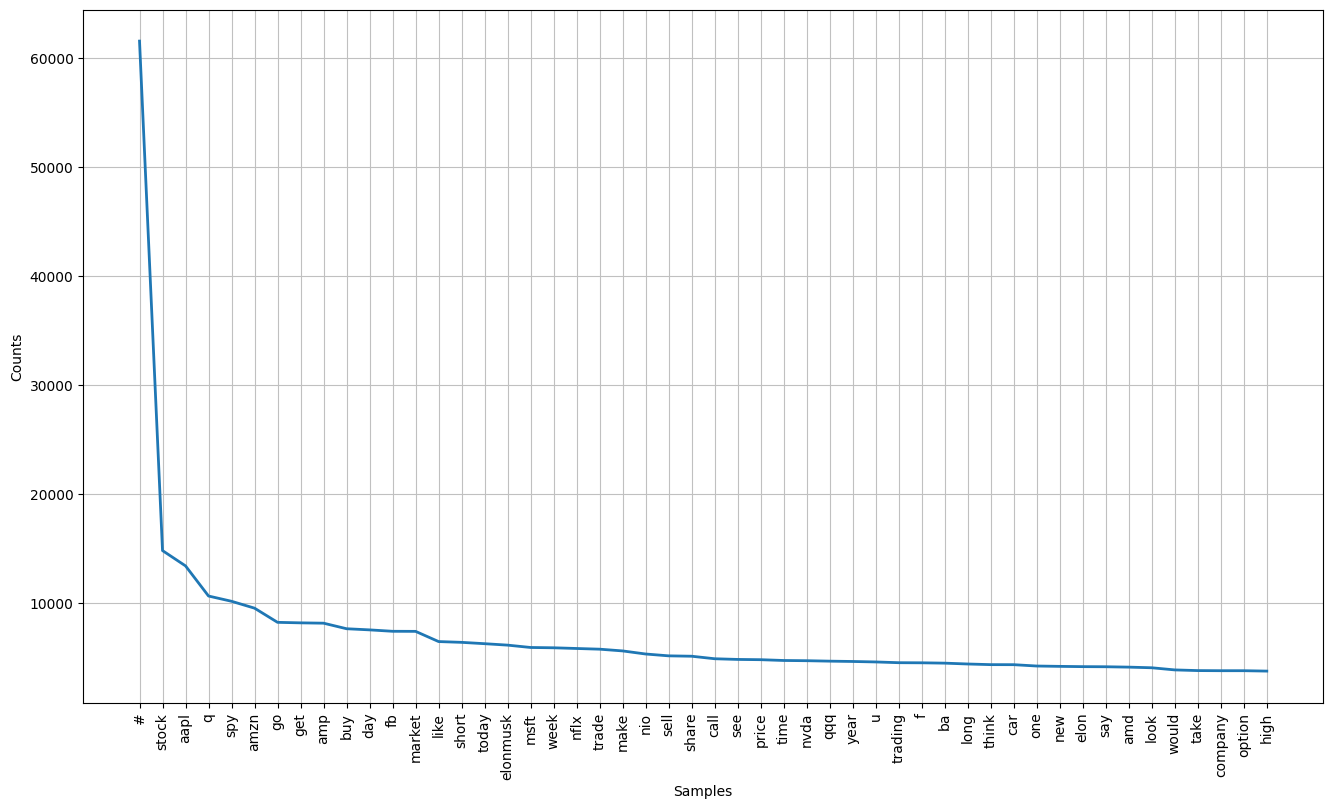

In [6]:
all_words_str = ' '.join(tweets_df.cleaned_tweet)
all_words_list = all_words_str.split()
word_freq = nltk.FreqDist(all_words_list)
 
plt.figure(figsize=(16,9))
plt.xticks(fontsize=10, rotation=90)
word_freq.plot(50, cumulative=False)

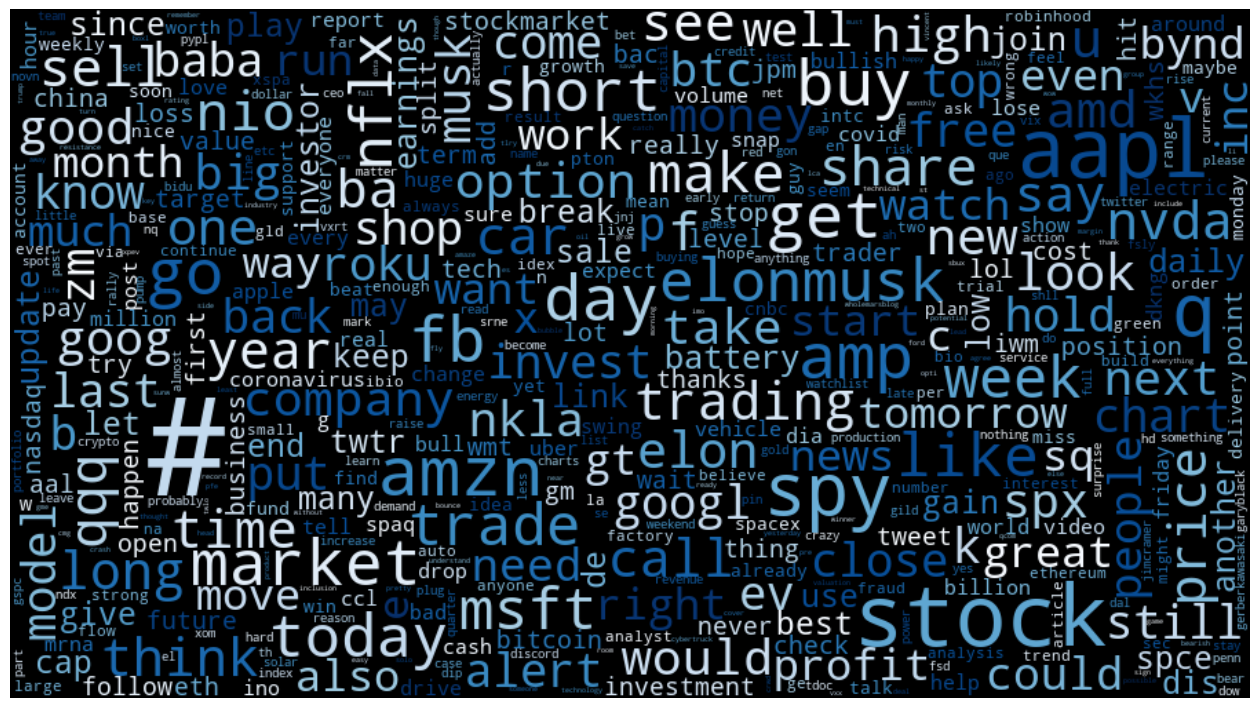

In [7]:
word_cloud = WordCloud(width=900, height=500, max_words=500, max_font_size=100, colormap='Blues',
                       normalize_plurals=True).generate_from_frequencies(word_freq)

plt.figure(figsize=(16,9))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

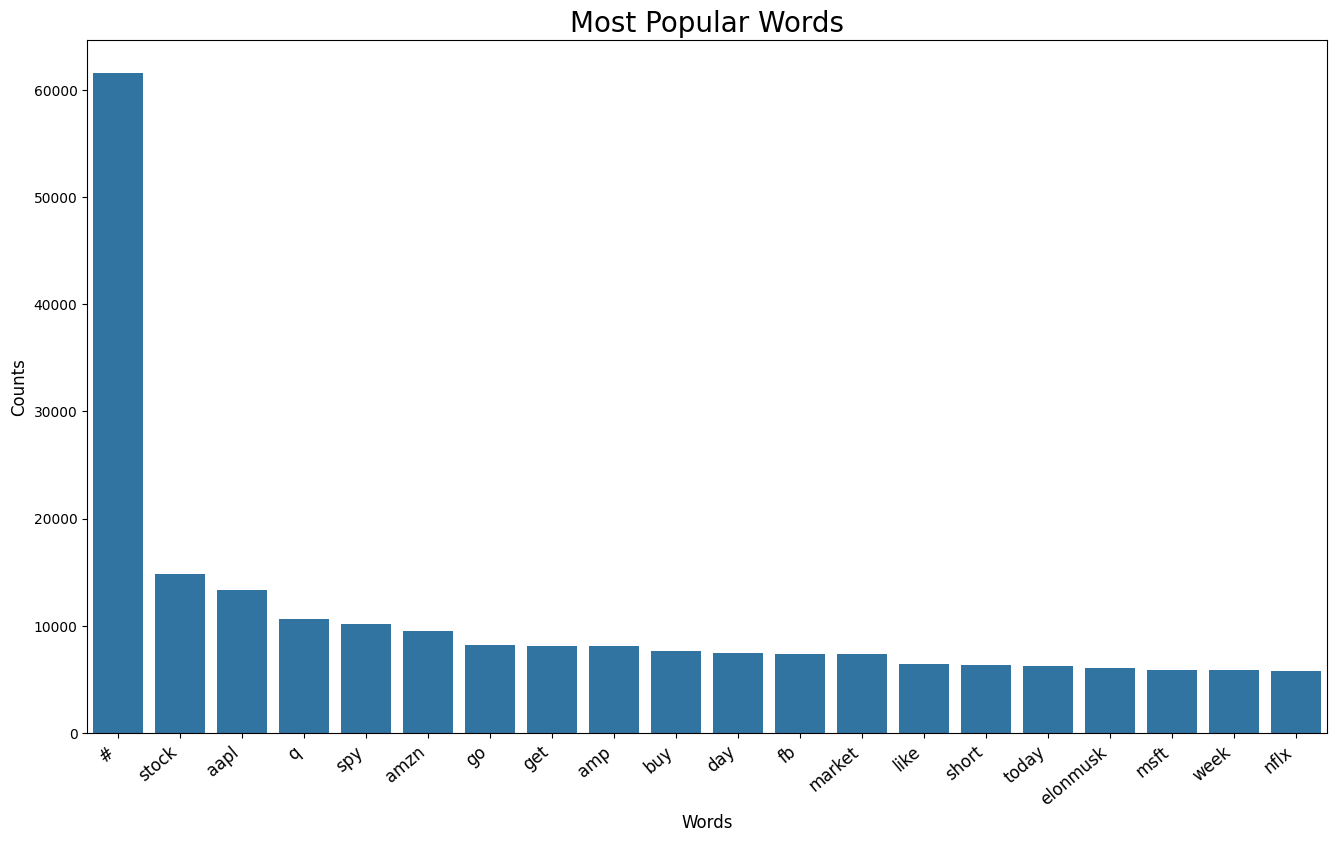

In [8]:
word_freq_df = pd.DataFrame({'Word': list(word_freq.keys()), 'Count': list(word_freq.values())}).sort_values(by='Count', ascending=False)
word_freq_df = word_freq_df.nlargest(columns='Count', n=20)

plt.figure(figsize=(16,9))
ax = sns.barplot(data=word_freq_df, x='Word', y='Count')
ax.set_ylabel('Counts', fontsize=12)
ax.set_xlabel('Words', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right', fontsize=12)
ax.set_title('Most Popular Words', fontsize=20)
plt.show()

In [9]:
tweets_df.to_csv('cleaned-tsla-tweets.csv', index=False)

In [10]:
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator, EMAIndicator

# Load dataset
df = pd.read_csv("data.csv", parse_dates=["Date"])
df.sort_values("Date", inplace=True)

# Price Returns
df["daily_return"] = df["Close"].pct_change()
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))

# Moving Averages
sma_short, sma_long = 10, 50
df["SMA_short"] = SMAIndicator(df["Close"], window=sma_short).sma_indicator()
df["SMA_long"] = SMAIndicator(df["Close"], window=sma_long).sma_indicator()
df["EMA_short"] = EMAIndicator(df["Close"], window=sma_short).ema_indicator()
df["EMA_long"] = EMAIndicator(df["Close"], window=sma_long).ema_indicator()

# Volatility Measures
df["volatility"] = df["daily_return"].rolling(20).std()
df["ATR"] = (df["High"] - df["Low"]).rolling(14).mean()

# Technical Indicators
df["RSI"] = RSIIndicator(df["Close"], window=14).rsi()
df["MACD"] = MACD(df["Close"]).macd()

bollinger = BollingerBands(df["Close"], window=20)
df["bollinger_h"] = bollinger.bollinger_hband()
df["bollinger_l"] = bollinger.bollinger_lband()

# Trend Indicators
df["momentum"] = df["Close"].diff(4)
df["ROC"] = df["Close"].pct_change(periods=4) * 100

# Seasonal Features
df["Day_of_week"] = df["Date"].dt.dayofweek
df["Month"] = df["Date"].dt.month
df["Quarter"] = df["Date"].dt.quarter

# Lag Features
df["lagged_return"] = df["daily_return"].shift(1)
df["lagged_close"] = df["Close"].shift(1)

# Volume-based Features
df["volume_change"] = df["Volume"].pct_change()
df["volume_sma"] = df["Volume"].rolling(20).mean()

# Price relative to metrics
df["price_to_sma"] = df["Close"] / df["SMA_short"]
df["high_low_range"] = df["High"] - df["Low"]

# Save final dataset
df.to_csv("final_data.csv", index=False)

print("Feature engineering complete! Dataset saved as 'final_data.csv'")


Feature engineering complete! Dataset saved as 'final_data.csv'
